## Click detection CNN model

In [2]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import importlib
import platform


/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook is designed to run on both a local MacOS-based system and Google Colab to utilize the available computing power for model training.

To run the notebook on Google Colab, the similar folder sctructure is required as for the local run with the subfolders and files for the datasets, model architecture, weights etc.

In [19]:
# define op system
system = platform.system()
system

# outputs: for MacOS: 'Darwin', for Linux: 'Linux'

'Darwin'

### 1. Import data and create the training, validation and test dataset

In [20]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [22]:
# import data from selected dataset

if system == 'Darwin':
    cwd = str(Path.cwd())
    parent_dir = os.path.dirname(cwd)
    audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
    audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

    audio_datasets = []
    if os.path.exists(audio_datasets_main_dir):
        for i in os.listdir(audio_datasets_main_dir):
            #if folder name does not start with a dot
            if i[0] != ".": 
                audio_datasets.append(i)
        audio_datasets.sort(key=sort_key_func)
    else:
        print("Audio dataset directory does not exist")

 # google colab
if system == "Linux":
    from google.colab import drive
    drive.mount("/content/gdrive")
    cwd = str(Path.cwd()) 
    parent_dir = cwd
    print(parent_dir)
    audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
    audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)
    print(audio_datasets_main_dir)

    audio_datasets = []
    if os.path.exists(audio_datasets_main_dir):
        for i in os.listdir(audio_datasets_main_dir):
            #if folder name does not start with a dot
            if i[0] != ".": 
                audio_datasets.append(i)
        audio_datasets.sort(key=sort_key_func)
    else:
        print("Audio dataset directory does not exist")
    

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise']


In [8]:
dataset_num = 0

dataset_dir = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num])

# find files ending with .npz (stored numpy data) in the dataset_dir, if there is no such file in the direcori print there is noe npz file in the directory
file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.npz')]
if len(file_list) == 0:
    print("No npz file in the directory")
else:
    print(file_list)
    npz_file_num = 0

    file_fullpath = os.path.join(dataset_dir, file_list[npz_file_num])

    # check if the saved dataset can be loaded
    data = np.load(file_fullpath)
    loaded_spec_chunks = data['spec_chunks']
    loaded_spec_chunk_labels = data['labels']

    # check dataset information
    print(loaded_spec_chunks[0].shape)
    print(len(loaded_spec_chunks))
    print(len(loaded_spec_chunk_labels))
    # count the number of positive labels in numpy array
    print(np.count_nonzero(loaded_spec_chunk_labels == 1))

['spec_dataset_ethernet_wo_added_noise.npz']
(128, 32)
11144
11144
240


In [9]:
# normalize spectrogram chunks

## update with the decibel scale min max used in real time detection!!!

def normalize_spectrogram_chunks(spec_chunks):
    # find global min and max values
    """global_min = np.min(spec_chunks)
    global_max = np.max(spec_chunks)"""

    # min and max dB values set in the preprocessing notebook
    global_min = -120 
    global_max = 0

    print(global_min, global_max)

    normalized_spectrograms = [(spec - global_min) / (global_max - global_min) for spec in spec_chunks]

    return normalized_spectrograms

spec_chunks_norm = normalize_spectrogram_chunks(loaded_spec_chunks)

print(spec_chunks_norm[0].shape)
print(np.min(spec_chunks_norm[0]), np.max(spec_chunks_norm[0]))

-120 0
(128, 32)
0.0 0.6716549


In [10]:
# split the dataset into training, validation and test sets

# create a dataframe to store the spectrogram chunks and their labels
df_spectrogram_dataset = pd.DataFrame(columns=['spectrogram', 'label'])

# add the spectrogram chunks and their labels to the dataframe
df_spectrogram_dataset['spectrogram'] = spec_chunks_norm
df_spectrogram_dataset['label'] = loaded_spec_chunk_labels

print(df_spectrogram_dataset.head())
print(df_spectrogram_dataset[df_spectrogram_dataset.label == 1].head())

# separate positive and negative samples in spec_chunks_norm dataset based on the labels in loaded_spec_chunk_labels
spec_chunks_OK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 1]
spec_chunks_NOK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 0]

# Function to split a dataframe according to the 60-20-20 ratio
def split_df(df):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)  # test_size = 0.2 --> 80% for training, 20% for validation and testing
    val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 10% for validation, 10% for testing
    return train, val, test

train_OK, val_OK, test_OK = split_df(spec_chunks_OK)
train_NOK, val_NOK, test_NOK = split_df(spec_chunks_NOK)

# Combine the corresponding sets
train_set = pd.concat([train_OK, train_NOK]).sample(frac=1, random_state=42) 
val_set = pd.concat([val_OK, val_NOK]).sample(frac=1, random_state=42)
test_set = pd.concat([test_OK, test_NOK]).sample(frac=1, random_state=42)

print(f"Train set size: {len(train_set)}, Validation set size: {len(val_set)}, Test set size: {len(test_set)}")
print(train_set.label.value_counts())
print(val_set.label.value_counts())
print(test_set.label.value_counts())
print(train_set[train_set.label == 1].head())

                                         spectrogram  label
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
                                           spectrogram  label
176  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
177  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
178  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
179  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
420  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
Train set size: 8915, Validation set size: 1114, Test set size: 1115
label
0    8723
1     192
Name: count, dtype: int64
label
0    1090
1      24
Name: count, dtype: int64
label
0    1091
1      24
Name: count, dtype: int64
                                           

In [11]:
# prepare data for model input

def prepare_data(df):
    X = np.stack(df['spectrogram'].values)  # convert spectrogram list to numpy array
    #X = np.expand_dims(X, axis=1)  # add channel dimension
    y = df['label'].values
    return X, y

X_train, y_train = prepare_data(train_set)
X_val, y_val = prepare_data(val_set)
X_test, y_test = prepare_data(test_set)

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape, '\n')

# convert to torch tensors
def to_tensor(X, y):
    X = torch.from_numpy(X).type(torch.float32).unsqueeze(1) # convert to torch and add channel dimension
    y = torch.from_numpy(y).type(torch.float32)
    return X, y

X_train_tens, y_train_tens = to_tensor(X_train, y_train)
X_val_tens, y_val_tens = to_tensor(X_val, y_val)
X_test_tens, y_test_tens = to_tensor(X_test, y_test)

# View the first five samples
print(X_train_tens.shape, y_train_tens.shape)
print(X_val_tens.shape, y_val_tens.shape)
print(X_test_tens.shape, y_test_tens.shape)

train data shape: (8915, 128, 32)
train targets shape: (8915,)
val data shape: (1114, 128, 32)
val targets shape: (1114,)
test data shape: (1115, 128, 32)
test targets shape: (1115,) 

torch.Size([8915, 1, 128, 32]) torch.Size([8915])
torch.Size([1114, 1, 128, 32]) torch.Size([1114])
torch.Size([1115, 1, 128, 32]) torch.Size([1115])


In [12]:
# create dataloaders for training, validation and test sets

BATCH_SIZE = 16

train_dataset = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
val_dataset = torch.utils.data.TensorDataset(X_val_tens, y_val_tens)
test_dataset = torch.utils.data.TensorDataset(X_test_tens, y_test_tens)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_loader)}")
print(f"Length of test dataloader: {len(val_loader)}")
print(f"Length of test dataloader: {len(test_loader)}")

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

Length of train dataloader: 558
Length of test dataloader: 70
Length of test dataloader: 70


(torch.Size([16, 1, 128, 32]), torch.Size([16]))

In [13]:
# check if GPU is available, if not use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [23]:
# model architecture

selected_model = "ClickDetectorCNN_v1.py"
#module = importlib.import_module(architecture_file[:-3])

cwd = str(Path.cwd())
if system == 'Darwin':
  model_architectures_dir = "01_modelArchitectures"
elif system == 'Linux':
  model_architectures_dir = "03_Click_Detection_Model/01_modelArchitectures"
model_architectures_dir_path = os.path.join(cwd, model_architectures_dir)
print(model_architectures_dir_path)
if os.path.exists(model_architectures_dir_path):
    sys.path.append(model_architectures_dir_path)
    model_module = importlib.import_module(selected_model[:-3])
    #from ClickDetectorCNN_v1 import ClickDetectorCNN
    ClickDetectorCNN = getattr(model_module, 'ClickDetectorCNN') #access the ClickDetectorCNN class
    model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
else:
    print("Model architectures directory does not exist")

model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
model

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/03_Click_Detection_Model/01_modelArchitectures


ClickDetectorCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [15]:
# model training

learning_rate = 0.001
epochs = 20

loss_fn = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

binary_threshold = 0.5

# early stopping parameters
patience = 3  # epochs to wait after last time validation loss improved
delta = 0.001  # minimum change in the validation loss
best_val_loss = float('inf')  # initialize best validation loss as infinity
patience_counter = 0  # counter for epochs since last improvement

train_losses, val_losses = [], []

def accuracy_fn(y_true, y_pred):
    binary_predictions = (y_pred > binary_threshold).float()
    correct = torch.eq(y_true, binary_predictions).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    
    #model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        model.train()
        
        # forward pass
        y_pred = model(X)
        y_pred = torch.squeeze(y_pred)

        # calculate loss per batch
        loss = loss_fn(y_pred, y.float())
        train_loss += loss # accumulatively add up the loss per epoch
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

    # average loss per batch per epoch
    train_loss /= len(train_loader)
    train_acc /= len(data_loader)
    train_losses.append(train_loss)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def validation_step(model: torch.nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    accuracy_fn,
                    device: torch.device = device):
    val_loss, val_acc = 0, 0
    
    #model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            val_pred = model(X)
            val_pred = torch.squeeze(val_pred)
            val_loss += loss_fn(val_pred, y.float()) # accumulatively add up the loss per epoch
            #val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1)) 
            val_acc += accuracy_fn(y_true=y, y_pred=val_pred)
        
        val_loss /= len(val_loader)
        val_acc /= len(data_loader)
        val_losses.append(val_loss)
    
    print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

    return val_loss

epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    val_loss = validation_step(data_loader=val_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

    # early stopping if there is no improvement in the validation loss
    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        patience_counter = 0  # reset counter
    else:
        patience_counter += 1  # increment counter
        print(f"No improvement in validation loss for {patience_counter} epochs")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/20 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [26]:
# Test the model on the test set
# variables for accumulatively adding up loss and accuracy 
test_loss, test_acc = 0, 0

all_preds = []
all_true_labels = []

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        # forward pass
        test_pred = model(X)
        test_pred = torch.squeeze(test_pred)
        
        # calculate loss accumatively
        test_loss += loss_fn(test_pred, y.float()) # accumulatively add up the loss per epoch

        # calculate accuracy
        binary_predictions = (test_pred > binary_threshold).float()

        test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        all_preds.extend(binary_predictions.tolist())
        all_true_labels.extend(y.tolist())
    
    # divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_loader)

    # divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_loader)

print(f"Test acc: {test_acc:.2f}%\n")

Test acc: 100.00%



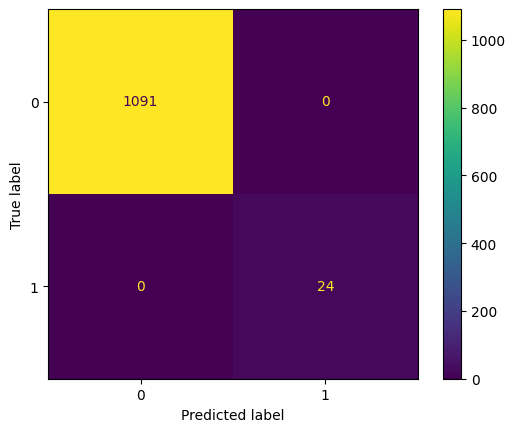

In [27]:
# plot out confusion matrix

cm = confusion_matrix(all_true_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()

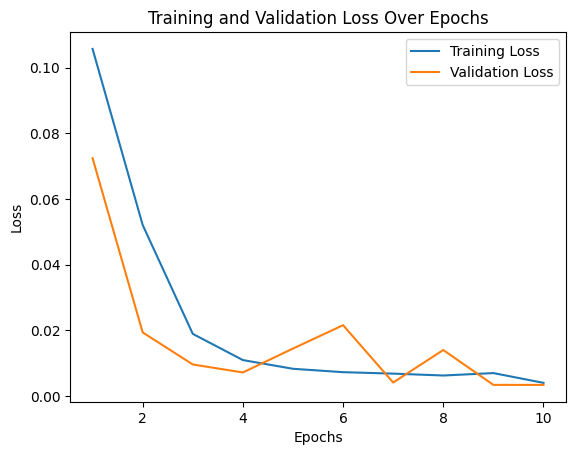

In [28]:
# print learning curves

train_loss_values = [loss.item() for loss in train_losses]
val_loss_values = [loss.item() for loss in val_losses]

epochs_range = range(1, len(train_loss_values) + 1)

plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [31]:
# save model

# define connector type
connector_type = "ethernet"

cwd = str(Path.cwd())
models_dir = "02_savedWeights"
models_dir_path = os.path.join(cwd, models_dir)
if not os.path.exists(models_dir_path):
    os.makedirs(models_dir_path)

# chek if there any model in the directory
model_files = [f for f in os.listdir(models_dir_path) if f.endswith('.pt')]

def extract_model_number(file_name):
    try:
        return int(file_name.split('_')[-1].split('.')[0])
    except ValueError:
        print("Latest model number could not be extracted")


# create file name with the highest number after the model_ prefix
if len(model_files) == 0:
    model_file_name = f"{connector_type}_det_model_0.pt"
else:
    model_files.sort(key=sort_key_func)
    highest_model_number = extract_model_number(model_files[-1])
    model_file_name = f"{connector_type}_det_model_{highest_model_number + 1}.pt"
    #model_file_name = f"{connector_type}_det_model_{int(model_files[-1].split('_')[1].split('.')[0]) + 1}.pt"

model_file_path = os.path.join(models_dir_path, model_file_name)
torch.save(model.state_dict(), model_file_path) # only saving the state_dict() only saves the learned parameters

